In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit
from convokit import TextParser, TensorDecomposer, Corpus, download

In [3]:
corpus = Corpus(filename=download("reddit-coarse-discourse-corpus"))

Dataset already exists at /Users/calebchiam/.convokit/downloads/reddit-coarse-discourse-corpus


In [4]:
full_convos = {c.id for c in corpus.iter_conversations() if c.check_integrity(verbose=False)}
corpus.filter_conversations_by(lambda convo: convo.id in full_convos)

for utt in corpus.iter_utterances():
    utt.timestamp = 0

In [5]:
import random

longest_path_ids = []
for convo in corpus.iter_conversations():
    longest_path = random.choice(convo.get_longest_paths())
    convo.meta['longest_path'] = len(longest_path)
    longest_path_ids.extend([utt.id for utt in longest_path])

In [6]:
longest_path_ids = set(longest_path_ids)
corpus = corpus.filter_utterances_by(lambda utt: utt.id in longest_path_ids)

In [7]:
annotation_types = set()
for utt in corpus.iter_utterances():
    for t in utt.meta['annotation-types']:
        annotation_types.add(t)
        
annotation_types = sorted(list(annotation_types))
annotation_types

['agreement',
 'announcement',
 'answer',
 'appreciation',
 'disagreement',
 'elaboration',
 'humor',
 'negativereaction',
 'other',
 'question']

In [8]:
for utt in corpus.iter_utterances():
    utt.meta['annot-dict'] = {k: 0 for k in annotation_types}
    for t in annotation_types:
        utt.meta[t] = 0
    for t in utt.meta['annotation-types']:
        utt.meta['annot-dict'][t] = 1
        utt.meta[t] = 1

In [9]:
LENGTH = 8
min_length = lambda utt: utt.meta['valid']

In [10]:
for convo in corpus.iter_conversations():
    utts = convo.get_chronological_utterance_list()
    for utt_idx in range(len(utts) - LENGTH):
        subset = utts[utt_idx: utt_idx + LENGTH]
        start_utt = utts[utt_idx]
        for idx, utt in enumerate(subset):
            start_utt.meta['annot-dict-{}'.format(idx+1)] = utt.meta['annot-dict']
        start_utt.meta['valid'] = True

for utt in corpus.iter_utterances():
    if 'valid' not in utt.meta:
        utt.meta['valid'] = False

In [11]:
next(corpus.iter_utterances(min_length)).meta

{'post_depth': 0,
 'majority_type': 'question',
 'majority_link': 'none',
 'annotation-types': ['question', 'question', 'question'],
 'annotation-links': ['none', 'none', 'none'],
 'ups': 6,
 'annot-dict': {'agreement': 0,
  'announcement': 0,
  'answer': 0,
  'appreciation': 0,
  'disagreement': 0,
  'elaboration': 0,
  'humor': 0,
  'negativereaction': 0,
  'other': 0,
  'question': 1},
 'agreement': 0,
 'announcement': 0,
 'answer': 0,
 'appreciation': 0,
 'disagreement': 0,
 'elaboration': 0,
 'humor': 0,
 'negativereaction': 0,
 'other': 0,
 'question': 1,
 'annot-dict-1': {'agreement': 0,
  'announcement': 0,
  'answer': 0,
  'appreciation': 0,
  'disagreement': 0,
  'elaboration': 0,
  'humor': 0,
  'negativereaction': 0,
  'other': 0,
  'question': 1},
 'annot-dict-2': {'agreement': 0,
  'announcement': 0,
  'answer': 1,
  'appreciation': 0,
  'disagreement': 0,
  'elaboration': 0,
  'humor': 0,
  'negativereaction': 0,
  'other': 0,
  'question': 0},
 'annot-dict-3': {'agreeme

In [57]:
qn_8 = 0
not_qn_8 = 0
for utt in corpus.iter_utterances(min_length):
    if utt.meta['annot-dict-8']['question'] == 1:
        qn_8 += 1
        utt.meta['ends_qn'] = True
    else:
        not_qn_8 += 1
        utt.meta['ends_qn'] = False

In [60]:
qn_8

219

In [61]:
not_qn_8

785

In [62]:
td = TensorDecomposer(feature_set=['annot-dict-{}'.format(idx) for idx in range(1, 7+1)], 
                      obj_type="utterance", tensor_func='tensortools-ncp-bcd', rank=20,
                     )

In [63]:
td.fit(corpus, selector=min_length)

Constructing tensor...Done.
Decomposing tensor...NCP_BCD: iteration 1, objective 0.8402063252791635, improvement inf.
NCP_BCD: iteration 2, objective 0.8159560107750384, improvement 0.02425031450412507.
NCP_BCD: iteration 3, objective 0.7893863695668956, improvement 0.02656964120814287.
NCP_BCD: iteration 4, objective 0.7643954856174847, improvement 0.024990883949410847.
NCP_BCD: iteration 5, objective 0.7453726317420252, improvement 0.019022853875459544.
NCP_BCD: iteration 6, objective 0.7271936431295002, improvement 0.018178988612524982.
NCP_BCD: iteration 7, objective 0.7099018601712256, improvement 0.017291782958274604.
NCP_BCD: iteration 8, objective 0.6948167081197497, improvement 0.01508515205147587.
NCP_BCD: iteration 9, objective 0.6810788553746728, improvement 0.013737852745076884.
NCP_BCD: iteration 10, objective 0.6691142887061773, improvement 0.011964566668495547.
NCP_BCD: iteration 11, objective 0.6585623595030681, improvement 0.010551929203109212.
NCP_BCD: iteration 12, 

In [64]:
td.transform(corpus, selector=min_length)

Directory already exists. Exiting summarize()


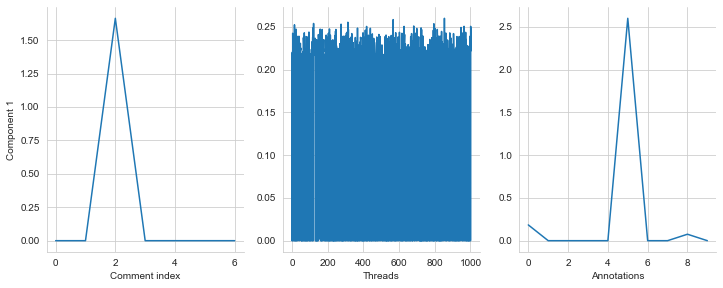

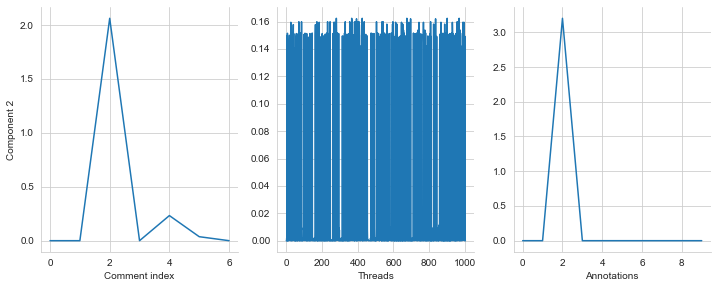

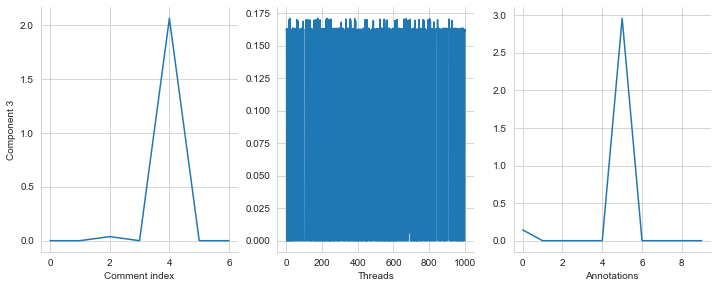

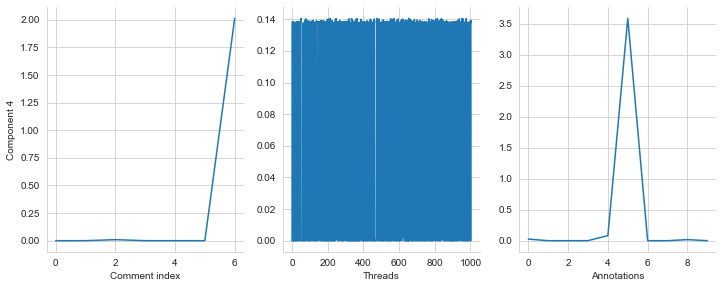

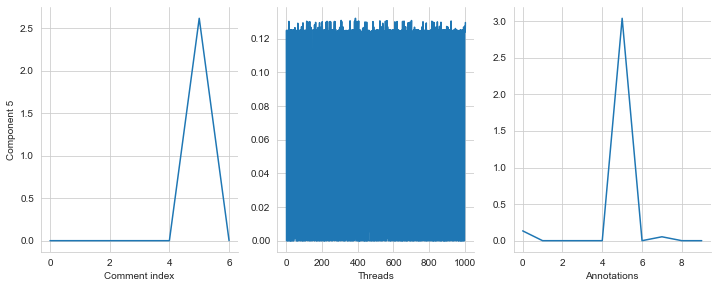

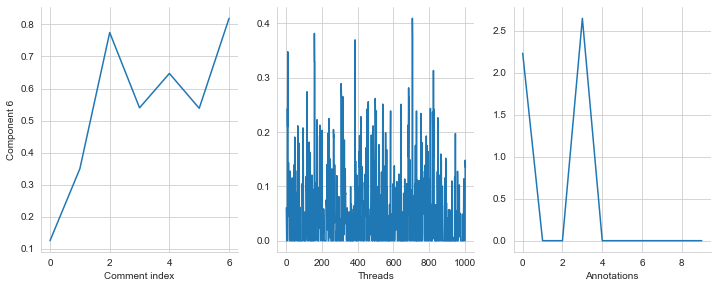

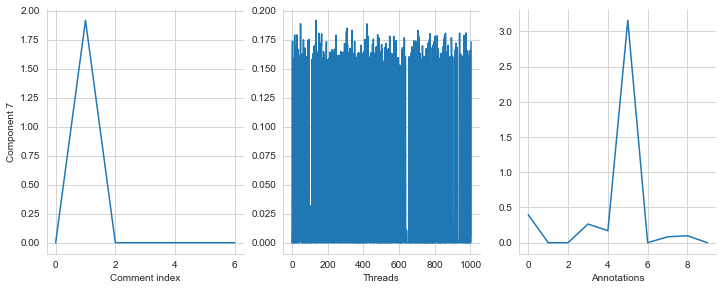

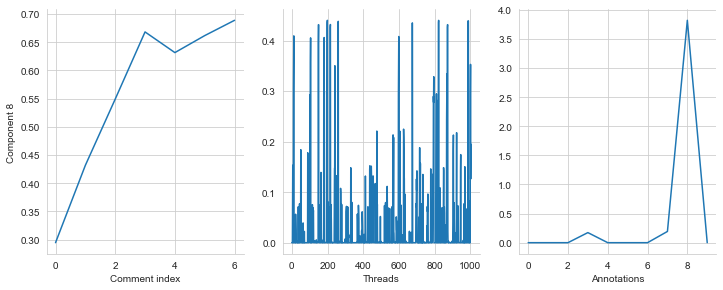

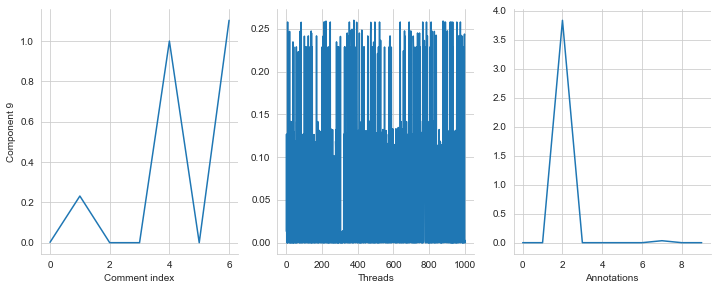

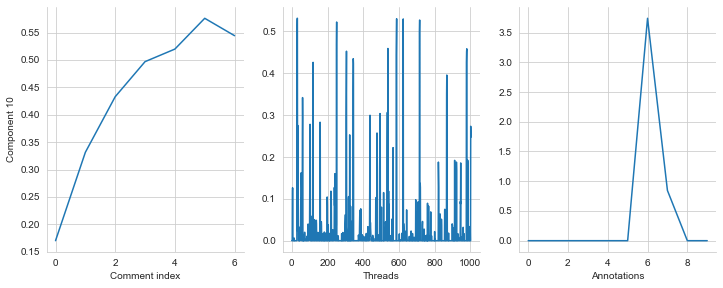

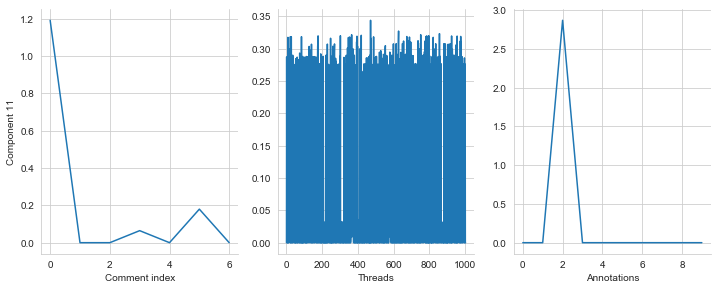

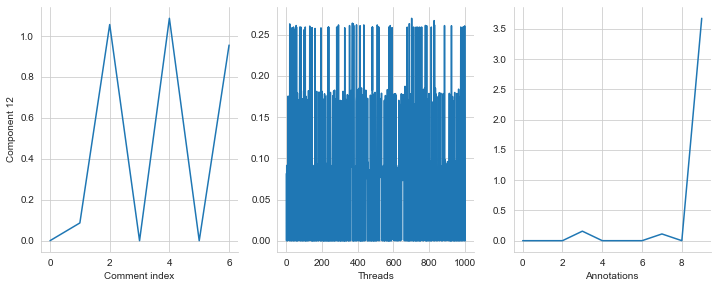

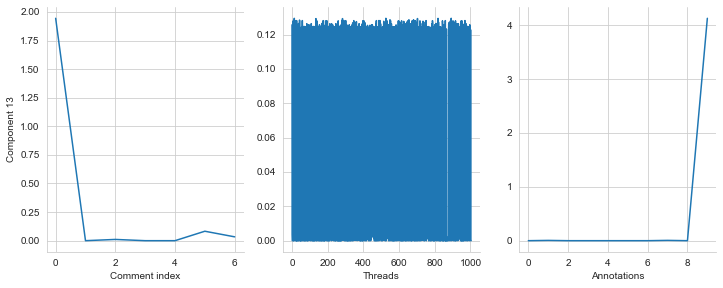

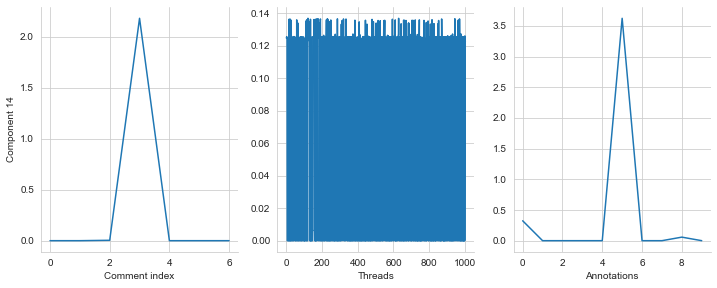

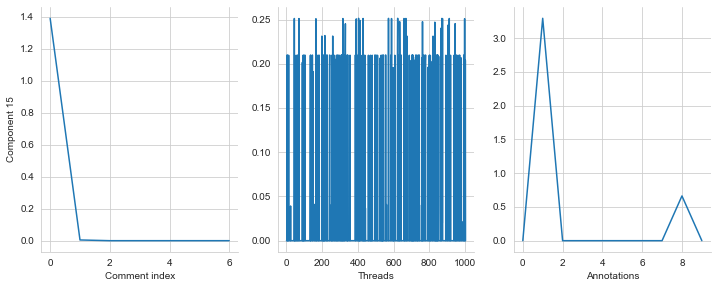

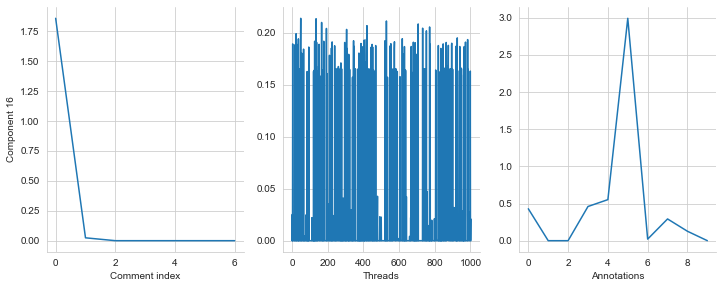

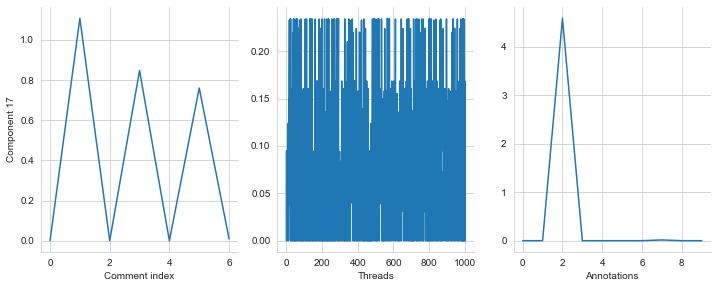

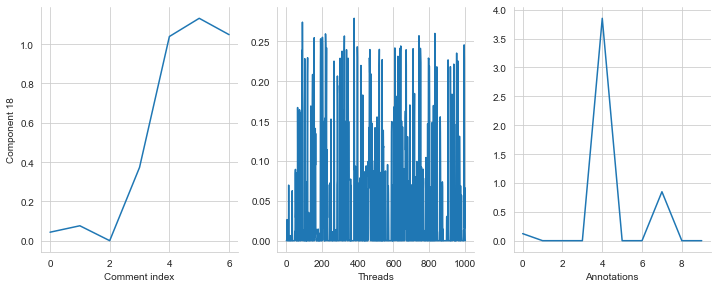

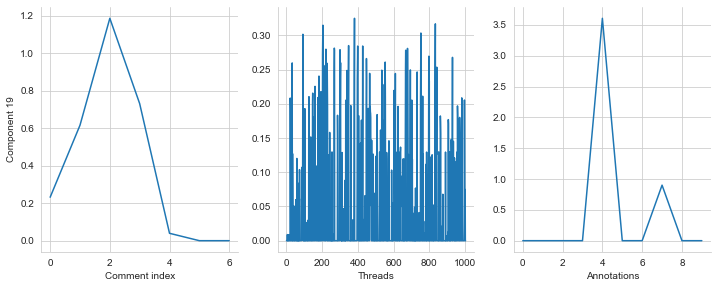

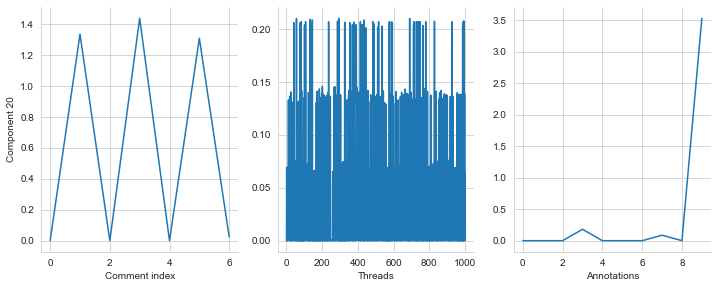

In [65]:
td.summarize(corpus, axis_names=['Comment index', 'Threads', 'Annotations'], 
             output_dir='convokit/tensor_decomposer/reports/coarse-discourse', 
             report_title='Coarse discourse', 
             liwc=True)

In [66]:
next(corpus.iter_utterances(selector=min_length)).get_vector('threads')

array([[0.        , 0.        , 0.16207104, 0.        , 0.12479977,
        0.06053565, 0.        , 0.        , 0.01328782, 0.        ,
        0.        , 0.08141624, 0.12566576, 0.12475287, 0.        ,
        0.        , 0.0944594 , 0.        , 0.        , 0.        ]])

In [113]:
from convokit import Classifier
import numpy as np
from convokit import VectorClassifier
from sklearn.metrics import roc_auc_score

### Tensor classifier

In [77]:
clf_tensor = VectorClassifier(obj_type='utterance', vector_name='threads', 
                             labeller=lambda utt: utt.meta['ends_qn'], 
                             clf_feat_name='tensor_pred', clf_prob_feat_name='tensor_pred_score')

Initialized default classification model (standard scaled logistic regression).


In [112]:
res = clf_tensor.evaluate_with_cv(corpus, selector=min_length)
np.mean(res)

Running a cross-validated evaluation...Done.


0.7848457711442787

In [80]:
clf_tensor.fit_transform(corpus, selector=min_length)

In [114]:
y_true, y_pred = clf_tensor.get_y_true_pred(corpus, selector=min_length)
roc_auc_score(y_true, y_pred)

0.5458773230957159

In [91]:
from sklearn.metrics import classification_report

In [82]:
print(clf_tensor.classification_report(corpus, selector=min_length))

              precision    recall  f1-score   support

       False       0.80      0.98      0.88       785
        True       0.63      0.11      0.19       219

    accuracy                           0.79      1004
   macro avg       0.71      0.55      0.53      1004
weighted avg       0.76      0.79      0.73      1004



In [86]:
clf_tensor.get_coefs(feature_names=['Component {}'.format(idx) for idx in range(1, 20+1)])

,coef
feat_name,
Component 9,0.365476
Component 17,0.250267
Component 2,0.213261
Component 20,0.091178
Component 10,0.086956
Component 19,0.068014
Component 15,0.066105
Component 11,0.065056
Component 6,0.061437


## Baseline accuracy

In [71]:
ctr = 0
total = 0
for utt in corpus.iter_utterances(min_length):
    ctr += int(utt.meta['ends_qn'])
    total += 1

In [72]:
base_accuracy = max(ctr/total, 1-ctr/total)
base_accuracy

0.7818725099601593

### Concat

In [94]:
for utt in corpus.iter_utterances(min_length):
    utt.meta['concat'] = dict()
    for idx in range(1, 6+1):
        d = utt.meta['annot-dict-{}'.format(idx)].copy()
        utt.meta['concat'].update({k+"_"+str(idx): v for k, v in d.items()})

In [95]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
model = Pipeline([("standardScaler", StandardScaler(with_mean=False)),
                            ("logreg", LogisticRegression(solver='liblinear'))])

In [96]:
from sklearn.preprocessing import scale

def scale_by_comment_idx(tensor):
    tensor = tensor.copy()
    for i in range(tensor.shape[0]):
        tensor[i, :, :] = scale(tensor[i, :, :])
    return tensor

In [100]:
clf = Classifier(obj_type="utterance", pred_feats=['concat'], labeller=lambda convo: convo.meta['ends_qn'],
                clf_feat_name='concat-pred', clf_prob_feat_name='concat-pred-score', clf=model
                )

In [104]:
res = clf.evaluate_with_cv(corpus, selector=min_length)
np.mean(res)

Using corpus objects...
Running a cross-validated evaluation...
Done.


0.765910447761194

In [106]:
clf.fit_transform(corpus, selector=min_length)

In [109]:
y_true, y_pred = clf.get_y_true_pred(corpus, selector=min_length)
roc_auc_score(y_true, y_pred)

0.5835238344530728

In [116]:
clf.get_coefs(feature_names=list(next(corpus.iter_utterances(min_length)).meta['concat']))

,coef
feat_name,
question_6,0.327229
negativereaction_1,0.278321
answer_2,0.250669
answer_3,0.250342
humor_4,0.230503
other_3,0.184702
disagreement_3,0.180519
agreement_4,0.148330
question_2,0.147448


### +SVD

In [121]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

In [119]:
concat_vals = []
for utt in corpus.iter_utterances(min_length):
    concat_vals.append(list(utt.meta['concat'].values()))

In [122]:
svd = TruncatedSVD(n_components=20, random_state=42)
svd.fit(concat_vals)

U, s, V = svd.transform(concat_vals) / svd.singular_values_, \
        svd.singular_values_, \
        svd.components_.T

In [125]:
corpus.set_vector_matrix(name='svd',
                        matrix=U,
                        columns=['Component_{}'.format(idx) for idx in range(1, 20+1)],
                        ids=[utt.id for utt in corpus.iter_utterances(min_length)])

In [126]:
U.shape

(1004, 20)

In [130]:
svd_clf = VectorClassifier(obj_type='utterance', vector_name='svd', 
                           labeller=lambda convo: convo.meta['ends_qn'])

Initialized default classification model (standard scaled logistic regression).


In [132]:
res = svd_clf.evaluate_with_cv(corpus, selector=min_length)
np.mean(res)

Running a cross-validated evaluation...Done.


0.785865671641791

In [168]:
svd_clf.fit_transform(corpus, selector=min_length)
y_true, y_pred = svd_clf.get_y_true_pred(corpus, selector=min_length)

In [172]:
print(svd_clf.classification_report(corpus, selector=min_length))

              precision    recall  f1-score   support

       False       0.80      0.99      0.88       785
        True       0.66      0.10      0.17       219

    accuracy                           0.79      1004
   macro avg       0.73      0.54      0.52      1004
weighted avg       0.77      0.79      0.73      1004



In [173]:
roc_auc_score(y_true, y_pred)

0.5409388360527004

In [155]:
idx_to_annot = {idx+1: v for idx, v in enumerate(annotation_types)}
idx_to_annot[0] = idx_to_annot[10]

from collections import defaultdict
def index_to_semantic(ls):
    retval = defaultdict(list)
    for idx in ls:
        comment_idx = idx // 10 + 1
        retval[idx_to_annot[idx % 10]].append(comment_idx)
    for k, v in retval.items():
        retval[k] = sorted(v)
    return retval

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

def std_scale_df(df):
    d = dict()
    for i in range(df.shape[0]):
        d[i+1] = std_scaler.fit_transform(np.array(df.iloc[i]).reshape(-1, 1)).flatten()
    return pd.DataFrame.from_dict(d).T

def get_component_decomposition(V):
    feat_df = pd.DataFrame(V, index=list(range(1, V.shape[0]+1)), columns=list(range(1, V.shape[1]+1))).T
    retval = dict()
    for i in range(feat_df.shape[0]):
        s = sorted(list(feat_df.iloc[i].items()), key=lambda x: x[1], reverse=True)
        neg = [x[0] for x in s if x[1] <= -1]
        pos = [x[0] for x in s if x[1] >= 1]
        retval[i+1] = {'neg': neg, 'pos': pos}
    return retval

In [152]:
feat_df = pd.DataFrame(V.T)
std_scaled_df = std_scale_df(feat_df)

In [158]:
decomposed = get_component_decomposition(std_scaled_df.T)

In [159]:
for component_idx in range(1, V.shape[1]+1):
    print("Component index: {}\n".format(component_idx))
    print("Positive:")
    print(dict(index_to_semantic(decomposed[component_idx]['pos'])))
    print("Negative:")
    print(dict(index_to_semantic(decomposed[component_idx]['neg'])))
    print("------------------------------\n")

Component index: 1

Positive:
{'disagreement': [2, 3, 4, 5, 6], 'other': [1], 'announcement': [2]}
Negative:
{'agreement': [2, 3, 4, 5, 6]}
------------------------------

Component index: 2

Positive:
{'other': [1, 3, 5], 'announcement': [2, 4, 6]}
Negative:
{'announcement': [1], 'disagreement': [2, 3, 4, 5, 6]}
------------------------------

Component index: 3

Positive:
{'announcement': [1, 3, 5], 'other': [2, 4, 6]}
Negative:
{'disagreement': [2, 3, 4, 5]}
------------------------------

Component index: 4

Positive:
{'announcement': [1, 4, 6], 'other': [3, 5], 'disagreement': [1, 2]}
Negative:
{'disagreement': [3], 'announcement': [2], 'other': [1]}
------------------------------

Component index: 5

Positive:
{'appreciation': [2, 3, 4, 5, 6], 'other': [4, 5], 'announcement': [5, 6]}
Negative:
{'announcement': [3], 'other': [2], 'disagreement': [4, 5, 6]}
------------------------------

Component index: 6

Positive:
{'other': [3], 'announcement': [4], 'disagreement': [5, 6], 'app

In [166]:
svd_clf.fit(corpus, selector=min_length)

In [167]:
svd_clf.get_coefs(feature_names=['Component_{}'.format(idx) for idx in range(1, 20+1)])

,coef
feat_name,
Component_3,0.553447
Component_8,0.203601
Component_16,0.138509
Component_5,0.132838
Component_17,0.118375
Component_1,0.080522
Component_15,0.074895
Component_6,0.052817
Component_9,0.052782


In [154]:
std_scaled_df

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
1,-0.836096,-0.002432,0.487628,-0.716242,-0.659509,-0.059370,-0.908933,-0.769780,-0.599441,2.636515,...,-0.427448,-1.005019,0.846333,-0.527548,0.303610,2.433852,-0.744608,-0.465017,-0.504132,0.604087
2,-0.108348,-0.366681,-1.180133,-0.044308,-0.303392,-0.960639,0.010959,-0.082507,-0.223157,2.996339,...,-0.054269,0.093754,2.551569,-0.030291,-0.602889,-1.199235,-0.058409,-0.207890,-0.002228,-0.201151
3,-0.126471,-0.029401,1.143322,-0.005345,-0.191669,-0.332631,-0.035485,-0.077649,-0.018598,0.018879,...,-0.091503,-0.085796,-0.231210,0.429576,-0.773088,-0.716830,-0.044935,-0.221752,0.139641,1.896736
4,0.143875,0.238170,2.000210,0.164925,0.125329,1.236180,-0.079258,0.027177,0.167381,-3.221540,...,-0.417062,-0.169967,2.451881,-0.193331,-0.951576,-0.890535,0.068800,-0.300201,-0.083538,-0.598100
5,-0.082175,-0.493044,0.902358,-0.344212,0.700252,-0.109712,-0.102013,0.030285,-0.534270,-0.317567,...,-0.384686,-0.139531,1.123513,-0.477589,2.374802,-1.752377,-0.273476,0.416147,-0.900430,-0.059326
6,-0.084235,-0.126978,0.122806,0.022559,0.279498,0.056464,0.061472,0.212515,0.002199,-0.408046,...,0.231789,-0.042691,-2.389729,0.145910,1.302720,1.557285,0.052002,0.302384,-0.052954,0.211718
7,-0.071103,-0.460037,0.263918,-0.248466,0.441995,-0.348759,-0.160685,0.048394,-0.403773,0.307477,...,-0.074347,0.021045,0.533702,-0.410269,1.667740,-0.173974,-0.234292,0.235469,-0.473906,-0.774906
8,0.016522,-0.076357,0.581078,-0.062833,-0.067303,-0.261438,-0.000694,-0.250229,-0.076509,0.221063,...,-0.385343,-0.023154,-1.404765,-0.406314,-0.178930,-4.844400,0.097669,-0.105375,-0.230179,5.112340
9,-0.455793,2.363893,-2.325364,-0.452340,-0.366729,-0.999471,-0.020879,-0.158648,1.512818,0.324368,...,-0.876854,-0.387361,-0.523653,-0.253143,0.401466,-1.353345,0.884188,0.436762,2.446978,-0.619766
10,-0.210958,-4.501888,4.254450,-0.116164,-0.282897,0.122404,-0.145070,0.007467,-0.188013,-0.108421,...,0.148062,-0.053906,-0.568602,0.888021,0.318523,-0.091599,0.043795,-0.624173,1.736881,-0.707766


In [92]:
from sklearn.decomposition import SparsePCA
from sklearn.model_selection import KFold
fold5 = KFold(5, True)

In [81]:
from convokit import extract_feats_and_label
X, y = extract_feats_and_label(corpus, "conversation", ['concat'], lambda x: x.meta['ends_disg'], long_8)

In [71]:
convo_ids = [convo.id for convo in corpus.iter_conversations(long_8)]

In [100]:
results = []
for train, test in fold5.split(X, y):
    clf = svm.SVC(C=0.02, kernel='linear', probability=True)
    pca = PCA(n_components=20)
    clf.fit(pca.fit_transform(X[train].toarray()), y[train])
    pred = clf.predict(pca.transform(X[test].toarray()))
    results.append(np.mean(pred == y[test]))
#     print(np.mean(clf.predict(X[test].toarray()) == y[test]))

In [101]:
np.mean(results)

0.7815868263473054

### Averaged

In [116]:
for convo in corpus.iter_conversations(long_8):
    convo.meta['avg'] = convo.meta['annot-dict-1'].copy()
    for idx in range(2, 6+1):
        d = convo.meta['annot-dict-{}'.format(idx)]
        for k, v in d.items():
            convo.meta['avg'][k] += v
    for k, v in convo.meta['avg'].items():
        convo.meta['avg'][k] = v / 6

In [117]:
clf_avg = Classifier(obj_type="conversation", pred_feats=['avg'], labeller=lambda convo: convo.meta['ends_disg'],
                clf_feat_name='avg-pred', clf_prob_feat_name='avg-pred-score', clf=model
                )

In [118]:
res = clf_avg.evaluate_with_cv(corpus, selector=long_8)

Using corpus objects...
Running a cross-validated evaluation...
Done.


In [119]:
np.mean(res)

0.80544625035643

In [16]:
disgmt_convos = []
for idx, convo in enumerate(corpus.iter_conversations(lambda convo: convo.meta['longest_path'] >= 8)):
    if convo.get_chronological_utterance_list()[7].meta['disagreement'] == 1:
        disgmt_convos.append(idx)

In [18]:
disgmt_convos = set(disgmt_convos)

In [23]:
import seaborn as sns
import numpy as np

In [26]:
td.thread_anomaly_threshold = 1.5

In [37]:
len(disgmt_convos) / 838

0.1515513126491647

In [41]:
for idx in range(9):
    pos_threads =set(td._get_anomalous_points(td.factors[1], idx, td.thread_anomaly_threshold)[0])
    print(f"Component: {idx+1}, Occurrence rate: {len(pos_threads & disgmt_convos) / len(pos_threads)}")

Component: 1, Occurrence rate: 0.7469879518072289
Component: 2, Occurrence rate: 0.08620689655172414
Component: 3, Occurrence rate: 0.02702702702702703
Component: 4, Occurrence rate: 0.09523809523809523
Component: 5, Occurrence rate: 0.10344827586206896
Component: 6, Occurrence rate: 0.08620689655172414
Component: 7, Occurrence rate: 0.029850746268656716
Component: 8, Occurrence rate: 0.10344827586206896
Component: 9, Occurrence rate: 0.08860759493670886


In [47]:
np.mean(td.factors[1], axis=0)

array([0.06673601, 0.05748065, 0.05819419, 0.10944852, 0.09016224,
       0.08617327, 0.10437975, 0.07824023, 0.07858829])

In [49]:
np.mean(td.factors[1][list(disgmt_convos)], axis=0)

array([0.21305235, 0.03913019, 0.0242907 , 0.10454886, 0.10133535,
       0.09066071, 0.09934187, 0.07538853, 0.06743886])

In [50]:
np.mean(td.factors[1][list(set(list(range(838))) - disgmt_convos)], axis=0)

array([0.04060075, 0.06075844, 0.06425009, 0.11032371, 0.08816648,
       0.08537171, 0.10527963, 0.0787496 , 0.08057982])

In [52]:
import pandas as pd 
df = pd.DataFrame()

In [53]:
collective = {i+1: v for i, v in enumerate(np.mean(td.factors[1], axis=0))}

In [54]:
disgmt_only = {i+1: v for i, v in enumerate(np.mean(td.factors[1][list(disgmt_convos)], axis=0))}

In [55]:
non_disgmt = {i+1: v for i, v in enumerate(np.mean(td.factors[1][list(set(list(range(838))) - disgmt_convos)], axis=0))}

In [56]:
pd.DataFrame({'collective': collective, 'disagreement': disgmt_only, 'non-disagreement': non_disgmt})

,collective,disagreement,non-disagreement
1,0.066736,0.213052,0.040601
2,0.057481,0.039130,0.060758
3,0.058194,0.024291,0.064250
4,0.109449,0.104549,0.110324
5,0.090162,0.101335,0.088166
6,0.086173,0.090661,0.085372
7,0.104380,0.099342,0.105280
8,0.078240,0.075389,0.078750
9,0.078588,0.067439,0.080580


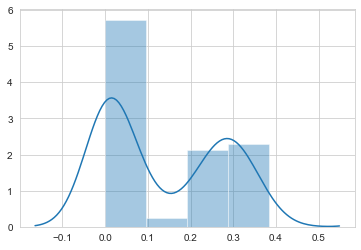

In [17]:
sns.distplot(td_disgmt.factors[1][:, 1])

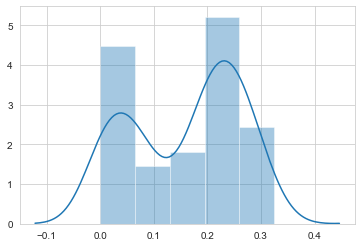

In [18]:
sns.distplot(td_disgmt.factors[1][:, 2])

In [76]:
arr0 = td_disgmt.factors[1][:, 0]
arr1 = td_disgmt.factors[1][:, 1]
arr2 = td_disgmt.factors[1][:, 2]

In [103]:
arr0[27]

0.3604255565872809

In [123]:
start_index = 55
arr0_top = set(list(np.argsort(arr0)[-start_index:]))
arr1_top = set(list(np.argsort(arr1)[-start_index:]))
arr2_top = set(list(np.argsort(arr2)[-start_index:]))

In [131]:
# appears in all three
len(arr0_top & arr1_top & arr2_top)

18

In [125]:
convo_df_subset = corpus.get_conversations_dataframe(selector=lambda convo: convo.meta['longest_path'] >= 8 and 
              convo.get_chronological_utterance_list()[7].meta['disagreement'] == 1)

In [126]:
for idx in (arr0_top & arr1_top & arr2_top):
    convo_id = convo_df_subset.iloc[idx].name
    corpus.get_conversation(convo_id).print_conversation_structure(lambda utt: str(utt.meta['disagreement']), limit=8)

0
    0
        1
            0
                1
                    1
                        1
                            1
0
    0
        1
            1
                1
                    1
                        1
                            1
0
    0
        1
            1
                1
                    1
                        1
                            1
0
    0
        1
            1
                1
                    1
                        1
                            1
0
    0
        0
            1
                1
                    1
                        1
                            1
0
    1
        1
            1
                1
                    1
                        1
                            1
0
    0
        1
            1
                1
                    1
                        1
                            1
0
    1
        0
            1
                1
                    1
                        1
      

In [132]:
len(arr0_top - (arr1_top | arr2_top))

15

In [129]:
for idx in (arr0_top - (arr1_top | arr2_top)):
    convo_id = convo_df_subset.iloc[idx].name
    corpus.get_conversation(convo_id).print_conversation_structure(lambda utt: str(utt.meta['disagreement']), limit=8)

0
    0
        0
            1
                0
                    0
                        1
                            1
0
    0
        1
            1
                1
                    0
                        1
                            1
0
    0
        0
            1
                0
                    0
                        0
                            1
0
    0
        0
            1
                0
                    0
                        0
                            1
0
    0
        1
            1
                0
                    0
                        1
                            1
0
    0
        1
            1
                0
                    0
                        0
                            1
0
    0
        0
            1
                0
                    0
                        0
                            1
0
    0
        1
            1
                0
                    0
                        0
      

In [135]:
len(arr2_top - (arr0_top | arr1_top))

17

In [136]:
for idx in (arr2_top - (arr0_top | arr1_top)):
    convo_id = convo_df_subset.iloc[idx].name
    corpus.get_conversation(convo_id).print_conversation_structure(lambda utt: str(utt.meta['disagreement']), limit=8)

0
    0
        0
            1
                0
                    1
                        1
                            1
0
    0
        1
            0
                0
                    1
                        1
                            1
0
    0
        0
            0
                0
                    1
                        1
                            1
0
    0
        0
            0
                0
                    1
                        1
                            1
0
    0
        1
            0
                0
                    1
                        1
                            1
0
    0
        0
            0
                0
                    1
                        1
                            1
0
    0
        0
            0
                0
                    0
                        1
                            1
0
    0
        0
            0
                0
                    1
                        1
      

In [73]:
len(arr2_top & arr1_top)

22

In [38]:
np.argwhere(arr2 >= np.quantile(td_disgmt.factors[2][:, 1], q=0.66)).flatten()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  15,  16,  17,  18,  21,  22,  23,  24,  25,  26,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  63,  64,  65,  66,  67,  69,  70,
        71,  72,  73,  74,  76,  77,  78,  79,  80,  81,  82,  84,  85,
        86,  88,  89,  90,  91,  92,  93,  94,  95,  97,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126])

### Emphasizing disagreements

In [20]:
corpus.random_utterance()

Utterance({'obj_type': 'utterance', '_owner': <convokit.model.corpus.Corpus object at 0x103f25390>, 'meta': {'post_depth': 3, 'majority_type': None, 'majority_link': 't1_d28jr77', 'annotation-types': ['humor', 'elaboration', 'other'], 'annotation-links': ['t1_d28jr77', 't1_d28jr77', 'none'], 'ups': 2, 'annot-dict': {'agreement': 0, 'announcement': 0, 'answer': 0, 'appreciation': 0, 'disagreement': 0, 'elaboration': 1, 'humor': 1, 'negativereaction': 0, 'other': 1, 'question': 0}, 'agreement': 0, 'announcement': 0, 'answer': 0, 'appreciation': 0, 'disagreement': 0, 'elaboration': 1, 'humor': 1, 'negativereaction': 0, 'other': 1, 'question': 0}, '_id': 't1_d294h9v', 'speaker': Speaker({'obj_type': 'speaker', '_owner': <convokit.model.corpus.Corpus object at 0x103f25390>, 'meta': {}, '_id': 'DSP_GC_98'}), 'conversation_id': 't3_4fg0ul', '_root': 't3_4fg0ul', 'reply_to': 't1_d28jr77', 'timestamp': 0, 'text': 'haha, im from philly so being a smart ass is in my blood. '})

In [26]:
annotation_types = ['agreement',
                     'announcement',
                     'answer',
                     'appreciation',
                     'disagreement',
                     'elaboration',
                     'humor',
                     'negativereaction',
                     'other',
                     'question']

In [29]:
no_maj = 0
no_maj_types = {t: 0 for t in annotation_types}
for utt in corpus.iter_utterances():
    if utt.meta['majority_type'] is None:
        no_maj += 1
        for t in utt.meta['annotation-types']:
            no_maj_types[t] += 1

In [31]:
for t in no_maj_types:
    no_maj_types[t] /= 3961

In [32]:
no_maj_types

{'agreement': 0.3082554910376168,
 'announcement': 0.05023983842464024,
 'answer': 0.26861903559707145,
 'appreciation': 0.3006816460489775,
 'disagreement': 0.24640242363039636,
 'elaboration': 0.7020954304468568,
 'humor': 0.18505427922241857,
 'negativereaction': 0.18808381721787426,
 'other': 0.3287048725069427,
 'question': 0.21560212067659681}

In [24]:
no_maj_elab / no_maj

0.7020954304468568

In [23]:
no_maj

3961

### TSNE

In [34]:
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [35]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=2000, verbose=1)

In [43]:
type_to_trunc = {
    'agreement': 'agmt',
    'announcement': 'anc',
    'answer': 'ans',
    'appreciation': 'appr',
    'disagreement': 'dsgmt',
    'elaboration': 'elab',
    'humor': 'hmr',
    'negativereaction': 'negR',
    'other': 'othr',
    'question': 'qn'
}

In [48]:
import random

In [64]:
for utt in corpus.iter_utterances():
    if utt.meta['majority_type'] is None:
        if 'disagreement' in utt.meta['annotation-types']:
            utt.meta['majority_type_'] = 'disagreement'
        else:
            utt.meta['majority_type_'] = random.choice(utt.meta['annotation-types'])
    else:
        utt.meta['majority_type_'] = utt.meta['majority_type']

In [65]:
for convo in corpus.iter_conversations():
    convo.meta['path'] = '-'.join([type_to_trunc[utt.meta['majority_type_']] for utt in convo.get_chronological_utterance_list()][:8])

In [ ]:
convo.meta['path']

In [66]:
df = corpus.get_conversations_dataframe(lambda c: c.meta['longest_path'] >= 8 and
                                        c.get_chronological_utterance_list()[7].meta['disagreement'] == 1)
projected_threads = tsne.fit_transform(td_disgmt.factors[1])
print(projected_threads.shape)

xs = [x for (x, y) in projected_threads]
ys = [y for (x, y) in projected_threads]

df['x'] = xs
df['y'] = ys

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 127 samples in 0.000s...
[t-SNE] Computed neighbors for 127 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 127 / 127
[t-SNE] Mean sigma: 0.213288
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.464378
[t-SNE] KL divergence after 1000 iterations: 0.353370
(127, 2)


In [67]:
df

,meta.annot-dict-1,meta.annot-dict-10,meta.annot-dict-11,meta.annot-dict-2,meta.annot-dict-3,meta.annot-dict-4,meta.annot-dict-5,meta.annot-dict-6,meta.annot-dict-7,meta.annot-dict-8,meta.annot-dict-9,meta.longest_path,meta.path,meta.subreddit,meta.title,meta.url,x,y
id,,,,,,,,,,,,,,,,,,
t3_1at5ow,"{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,NaN,"{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 1, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,8,qn-ans-agmt-qn-ans-dsgmt-dsgmt-dsgmt,askreddit,What book do you think is beautifully written?,https://www.reddit.com/r/AskReddit/comments/1a...,2.604131,-0.293164
t3_24ffw3,"{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,NaN,"{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,8,qn-ans-dsgmt-dsgmt-dsgmt-dsgmt-dsgmt-dsgmt,askreddit,What is one thing you should never give up on?,https://www.reddit.com/r/AskReddit/comments/24...,-1.041959,4.421836
t3_no05m,"{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,NaN,"{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,8,qn-ans-qn-ans-qn-ans-dsgmt-dsgmt,askreddit,Why do you not believe in aliens?,https://www.reddit.com/r/AskReddit/comments/no...,8.779455,0.771824
t3_1mm7er,"{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,NaN,"{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,8,qn-ans-qn-ans-elab-dsgmt-elab-dsgmt,askuk,UK Broadband/ISP subreddits?,https://www.reddit.com/r/AskUK/comments/1mm7er...,5.996558,4.133040
t3_3yvz6m,"{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,NaN,"{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 1, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,8,qn-ans-elab-dsgmt-qn-ans-dsgmt-elab,buttcoin,"Do most butters accept global warming? If so, ...",https://www.reddit.com/r/Buttcoin/comments/3yv...,1.988119,0.417150
t3_1tqv73,"{'agreement': 0, 'announcement': 1, 'answer': ...",NaN,NaN,"{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 1, 'announcement': 0, 'answer': ...","{'agreement': 1, 'announcement': 0, 'answer': ...","{'agreement': 1, 'announcement': 0, 'answer': ...","{'agreement': 1, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,8,anc-dsgmt-dsgmt-dsgmt-agmt-agmt-dsgmt-dsgmt,cfb,SI's 'Next Texas Head Coach Bracket' is in the...,https://www.reddit.com/r/CFB/comments/1tqv73/s...,0.772290,-9.832353
t3_12uk6w,"{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreeme

In [69]:
import plotly.express as px
fig = px.scatter(df, x='x', y='y', hover_data=['meta.path'])
fig.show()

In [60]:
df.shape

(127, 18)